In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as pl
from matplotlib.collections import LineCollection
import matplotlib.gridspec as gridspec

import seaborn as sns
import altair as alt
import scipy.stats as sci_stats
from collections import Counter
from glob import glob

In [2]:
# This dictionary changes the recorded generation numbers to the correct generation numbers
# Since P3 only does 8 gens/day it is very different, the other differences are due to little recording errors
gen_fixer = {70: {'P1': 70, 'P2': 70, 'P3': 56, 'P4': 70},
             550: {'P1': 560, 'P2': 560, 'P3': 448, 'P4': 560},
             1410: {'P1': 1410, 'P2': 1410, 'P3': 1128, 'P4': 1410},
             2640: {'P1': 2640, 'P2': 2640, 'P3': 2104, 'P4': 2640},
             3630: {'P1': 3660, 'P2': 3660, 'P3': 2920, 'P4': 3660},
             5150: {'P1': 5170, 'P2': 5170, 'P3': 4128, 'P4': 5170},
             7530: {'P1': 7550, 'P2': 7560, 'P3': 6040, 'P4': 7560},
             10150: {'P1': 10190, 'P2': 10200, 'P3': 8096, 'P4': 10200}}

## I observe x-contam in V2Tn_1, T0 and T2, especially T2. The best way to remove it I think is directly from the observation of unrealistic trajectories based on their log frequency trajectories at T2

## Here I will justify just doing this on V2Tn_1 at T2:

In [3]:
gens = [70, 1410, 2640, 5150, 7530, 10150]
tps_done = [i.split('/')[-1] for i in glob('/n/holyscratch01/desai_lab/mjohnson/V2Tn/output/s_estimation_V2/*')]
pops = sorted(set([i.split('_')[1] for i in tps_done]))

In [4]:
assay_d = {
    'V2Tn_1': ['G10150_rep1', 'G7530_rep1', 'G5150_rep1', 'G2640_rep1'],
    'V2Tn_2': ['G1410_rep1', 'G70_rep1', 'G10150_rep2', 'G7530_rep2'],
    'V2Tn_3': ['G5150_rep2', 'G2640_rep2', 'G1410_rep2', 'G70_rep2']
}

In [5]:
rep_d = pd.read_csv('../accessory_files/V2Tn_replicate_info.csv')
rep_info = {i[0]: i[1:] for i in rep_d.as_matrix(['Pop_timepoint', 'Clone_A', 'Clone_B'])}
base = '/n/holyscratch01/desai_lab/mjohnson/V2Tn/output/'
assay_wise = {a: [[0,0], [0,0], [0,0]] for a in assay_d}
assay_wiser = {a: [[0,0], [0,0], [0,0]] for a in assay_d}
for g in gens:
    for rep in range(2):
        for pop in pops:
            samp = 'G'+str(g)+'_'+pop
            ri = rep_info[samp][rep]
            assay, well = ri.split('.')
            try:
                df = pd.read_csv(base+assay+'/TP-'+well+'_counts.csv')
                cols = [i for i in df if 'V2Tn' in i and 'UMI' not in i]
                for c in cols:
                    #print(c, np.sum(test[c]))
                    df[c+'_freq'] = df[c]/np.sum(df[c])
                if len(cols) == 5:
                    for i in range(1,4):
                        t2_log = np.log(df[cols[i]+'_freq'])
                        t1_log = np.log(df[cols[i-1]+'_freq'])
                        t3_log = np.log(df[cols[i+1]+'_freq'])
                        fail = df[(t2_log > t1_log+0.5) & (t2_log > t3_log+0.5)]
                        assay_wise[assay][i-1][0] += len(fail)
                        assay_wise[assay][i-1][1] += len(df)
                        assay_wiser[assay][i-1][0] += np.sum(fail[cols[i]])
                        assay_wiser[assay][i-1][1] += np.sum(df[cols[i]])
            except FileNotFoundError:
                print('No file:', samp+rep)

/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
/n/home13/mjohnson/anaconda3/envs/milo_py37/lib/python3.7/site-packages/pandas/core/series.py:856: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


# T2 in V2Tn_1 is the only internal timepoint where this spiky-ness is common, but also it is still less than 1% of reads that are excluded on average:

Text(0.5, 1.0, 'Fraction of reads from\nbarcodes failing heuristic test')

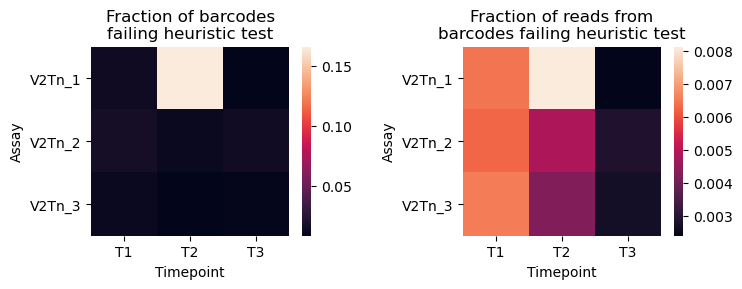

In [6]:
fig, subs = pl.subplots(1, 2, figsize=(8, 2.5), dpi=100)
pl.subplots_adjust(wspace=0.5)
mat = []
mat2 = []
for assay in ['V2Tn_1', 'V2Tn_2', 'V2Tn_3']:
    mat.append([])
    mat2.append([])
    for i in range(3):
        mat[-1].append(assay_wise[assay][i][0]/assay_wise[assay][i][1])
        mat2[-1].append(assay_wiser[assay][i][0]/assay_wiser[assay][i][1])
        
sns.heatmap(mat, xticklabels = ['T1', 'T2', 'T3'], yticklabels = ['V2Tn_1', 'V2Tn_2', 'V2Tn_3'], ax=subs[0])
subs[0].tick_params(which='both', rotation=0)
subs[0].set_xlabel('Timepoint')
subs[0].set_ylabel('Assay')
subs[0].set_title('Fraction of barcodes\nfailing heuristic test')

sns.heatmap(mat2, xticklabels = ['T1', 'T2', 'T3'], yticklabels = ['V2Tn_1', 'V2Tn_2', 'V2Tn_3'], ax=subs[1])
subs[1].tick_params(which='both', rotation=0)
subs[1].set_xlabel('Timepoint')
subs[1].set_ylabel('Assay')
subs[1].set_title('Fraction of reads from\nbarcodes failing heuristic test')
#fig.savefig('../../Figures/supp_figs/BC_exclusion_heuristics.png', background='transparent', bbox_inches='tight', pad_inches=0.1)


In [7]:
ref_edges = ['ACAACCTACCTGCTA','TCAAAACGGAGTGTT','GTTGGGCGCTTAAAG','CGATGATGATGATGA']
#ref_edges = ['ACAACCTACCTGCTA']

def plot_many(sub, df, cols, color):
    tmp = np.array(np.log10(np.clip(df[[c+'_freq' for c in cols]], 10**-6, 1)))
    line_data = np.zeros((tmp.shape[0], tmp.shape[1], 2))
    line_data[:,:,1] = tmp
    line_data[:,:,0] = np.tile([0,1,2,3,4], (tmp.shape[0],1))
    lines = LineCollection(line_data, color=color, alpha=0.5, linewidths=1)
    sub.add_collection(lines)

def plot_criteria(test, sub, criteria, samp, only_refs=True):
    cols = [i for i in test if 'V2Tn' in i and 'UMI' not in i if np.sum(test[i])>5000]
    if len(cols)>2:
        col_sums = {c: np.sum(test[c]) for c in cols}
        for c in cols:
            #print(c, np.sum(test[c]))
            test[c+'_freq'] = test[c]/np.sum(test[c])
        if only_refs:
            test = test[test['Edge'].isin(ref_edges)]
        t1 = criteria(test, cols, col_sums)
        t2 = test[~test['BC'].isin(set(t1['BC']))]
        #print(samp, len(t1)/len(test))
        plot_many(sub, t2, cols, 'k')
        plot_many(sub, t1, cols, 'r')
        if np.sum(t2[cols[2]]) < 200:
            sub.set_xticks([])
            sub.set_yticks([])
            sns.despine(left=True, bottom=True, ax=sub)
        else:
            sub.set_ylim([-6, 0])
            sub.set_xlim([0, 4])
            sub.set_xticks([0, 2, 4])
            sub.set_xticklabels([0, 16, 32])

        if len(cols) == 5 and np.sum(test[cols[2]]) > 1000:
            return np.sum(t1[cols[2]])/np.sum(test[cols[2]])
        else:
            return np.nan
    else:
        return np.nan

def alt(df, cols, cs):
    t2_log = np.log(df[cols[2]+'_freq'])
    t1_log = np.log(df[cols[1]+'_freq'])
    t3_log = np.log(df[cols[3]+'_freq'])
    return df[(t2_log > t1_log+0.5) & (t2_log > t3_log+0.5)]


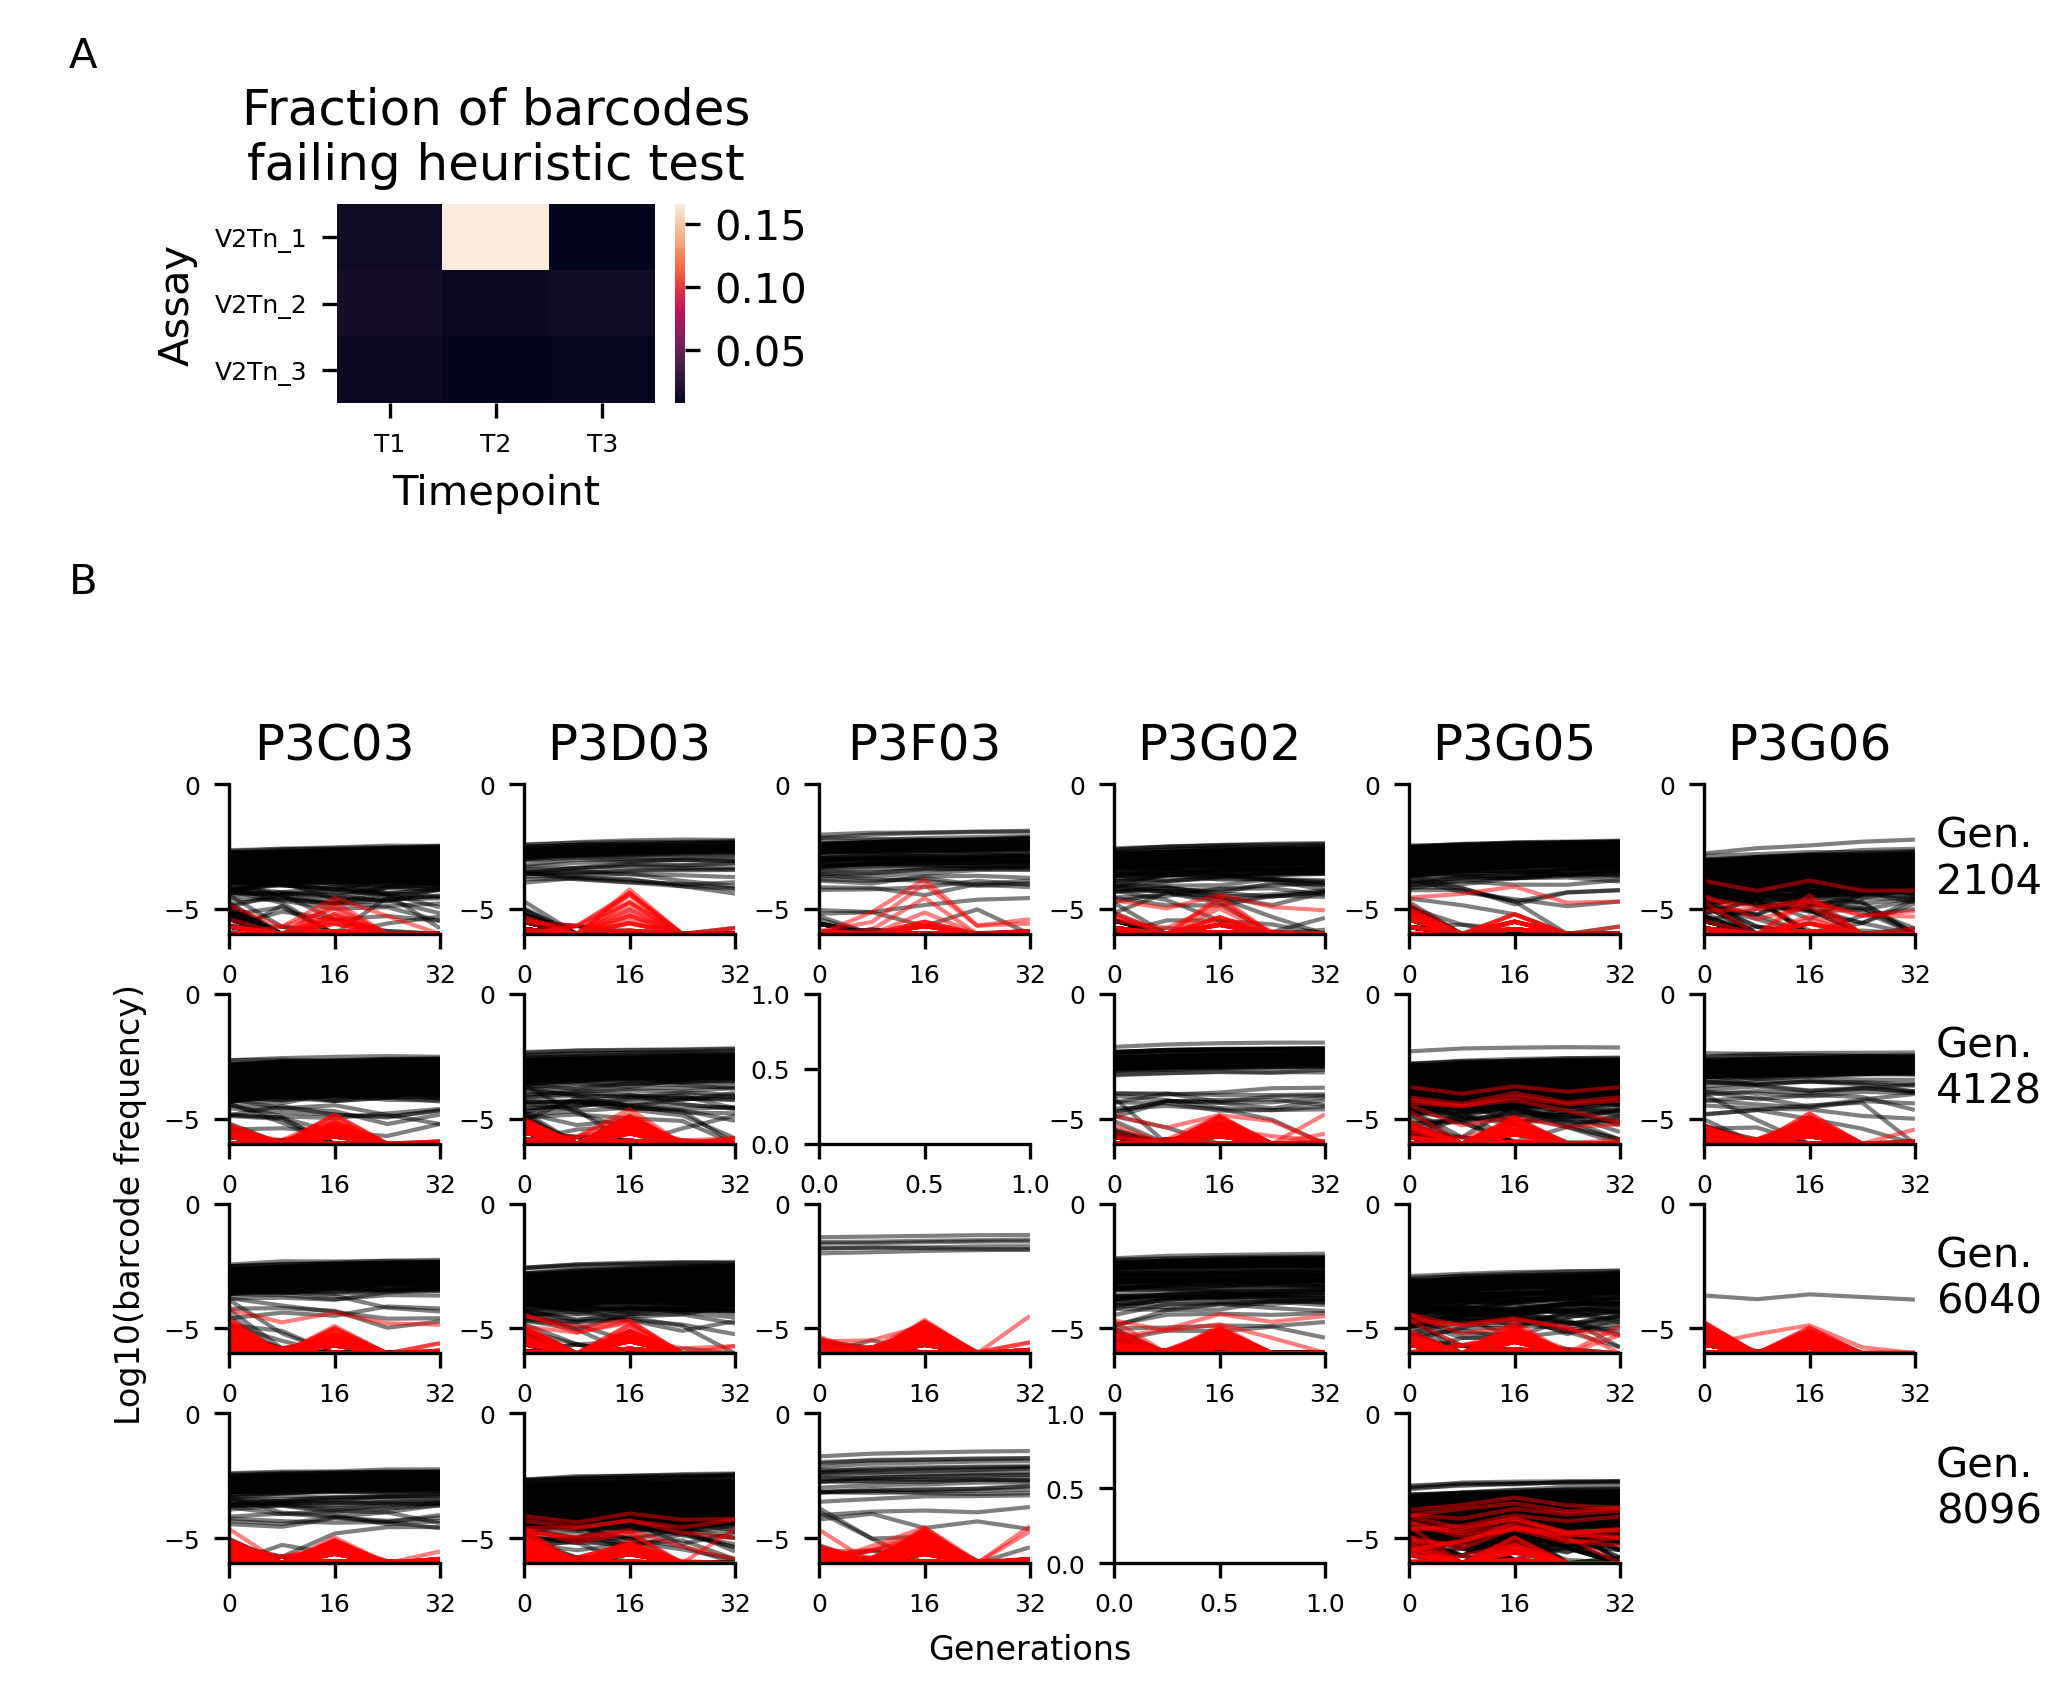

In [8]:
fig = pl.figure(figsize=(7.25, 6), dpi=300)
gs0 = gridspec.GridSpec(12, 16)
hm_gs = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs0[:2,1:5])
hm_sub = pl.Subplot(fig, hm_gs[0])
fig.add_subplot(hm_sub)
subs_gs = gridspec.GridSpecFromSubplotSpec(4, 6, subplot_spec=gs0[5:,:])
subps = [[pl.Subplot(fig, subs_gs[i, j]) for j in range(6)] for i in range(4)]
jnk = [fig.add_subplot(subps[i][j]) for j in range(6) for i in range(4)]   
pl.subplots_adjust(hspace=0.4, wspace=0.4)

sns.heatmap(mat, xticklabels = ['T1', 'T2', 'T3'], yticklabels = ['V2Tn_1', 'V2Tn_2', 'V2Tn_3'], ax=hm_sub)
hm_sub.tick_params(which='both', rotation=0)
hm_sub.set_xlabel('Timepoint')
hm_sub.set_ylabel('Assay')
hm_sub.set_title('Fraction of barcodes\nfailing heuristic test')
hm_sub.tick_params(labelsize=6)

i = 0
p3_pops = [p for p in pops if p[:2]=='P3']
percents_excluded = dict()
for g in gens[2:]:
    subs = subps[i]
    subs[-1].annotate('Gen.\n'+str(gen_fixer[g]['P3']), xy=(1.1, 0.5), xycoords='axes fraction', ha='left', va='center')
    if g == 7530:
        subs[0].set_ylabel('Log10(barcode frequency)', fontsize=8, y=1)
    if g == 10150:
        subs[2].set_xlabel('Generations', fontsize=8, x=1)
    for sub in subs:
        sub.tick_params(labelsize=6)
        sns.despine(ax=sub)
        
    i += 1
    j = 0
    for pop in p3_pops:
        if i == 1:
            subs[j].set_title(pop)
        samp = 'G'+str(g)+'_'+pop
        ri = rep_info[samp][0]
        assay, well = ri.split('.')
        try:
            percents_excluded[samp] = plot_criteria(pd.read_csv(base+assay+'/TP-'+well+'_counts.csv'), subs[j], alt, samp)
            
        except FileNotFoundError:
            subs[j].set_xticks([])
            subs[j].set_yticks([])
            sns.despine(left=True, bottom=True, ax=subs[j])
            print(samp)
        j += 1

pl.annotate('A', fontsize=10, xy=(0.04, 0.96), xycoords="figure fraction", horizontalalignment="center")
pl.annotate('B', fontsize=10, xy=(0.04, 0.65), xycoords="figure fraction", horizontalalignment="center")
fig.savefig('../../Figures/supp_figs/BC_exclusion_v2.pdf', background='transparent', bbox_inches='tight', pad_inches=0.1)

In [9]:
sdat_V2 = {i.split('/')[-2]: pd.read_csv(i) for i in glob('/n/holyscratch01/desai_lab/mjohnson/V2Tn/output/s_estimation_V2/*/*_edge_s.csv') if 'rep' not in i}
sdat_V1 = {i.split('/')[-2]: pd.read_csv(i) for i in glob('/n/holyscratch01/desai_lab/mjohnson/VTn/output/s_estimation_V2/*/*_edge_s.csv') if 'rep' not in i}

In [10]:
p1_pops = ['P1B04','P1C04','P1C05','P1D03','P1F05','P1G04']
p3_pops = ['P3C03','P3D03','P3F03','P3G02','P3G05','P3G06']

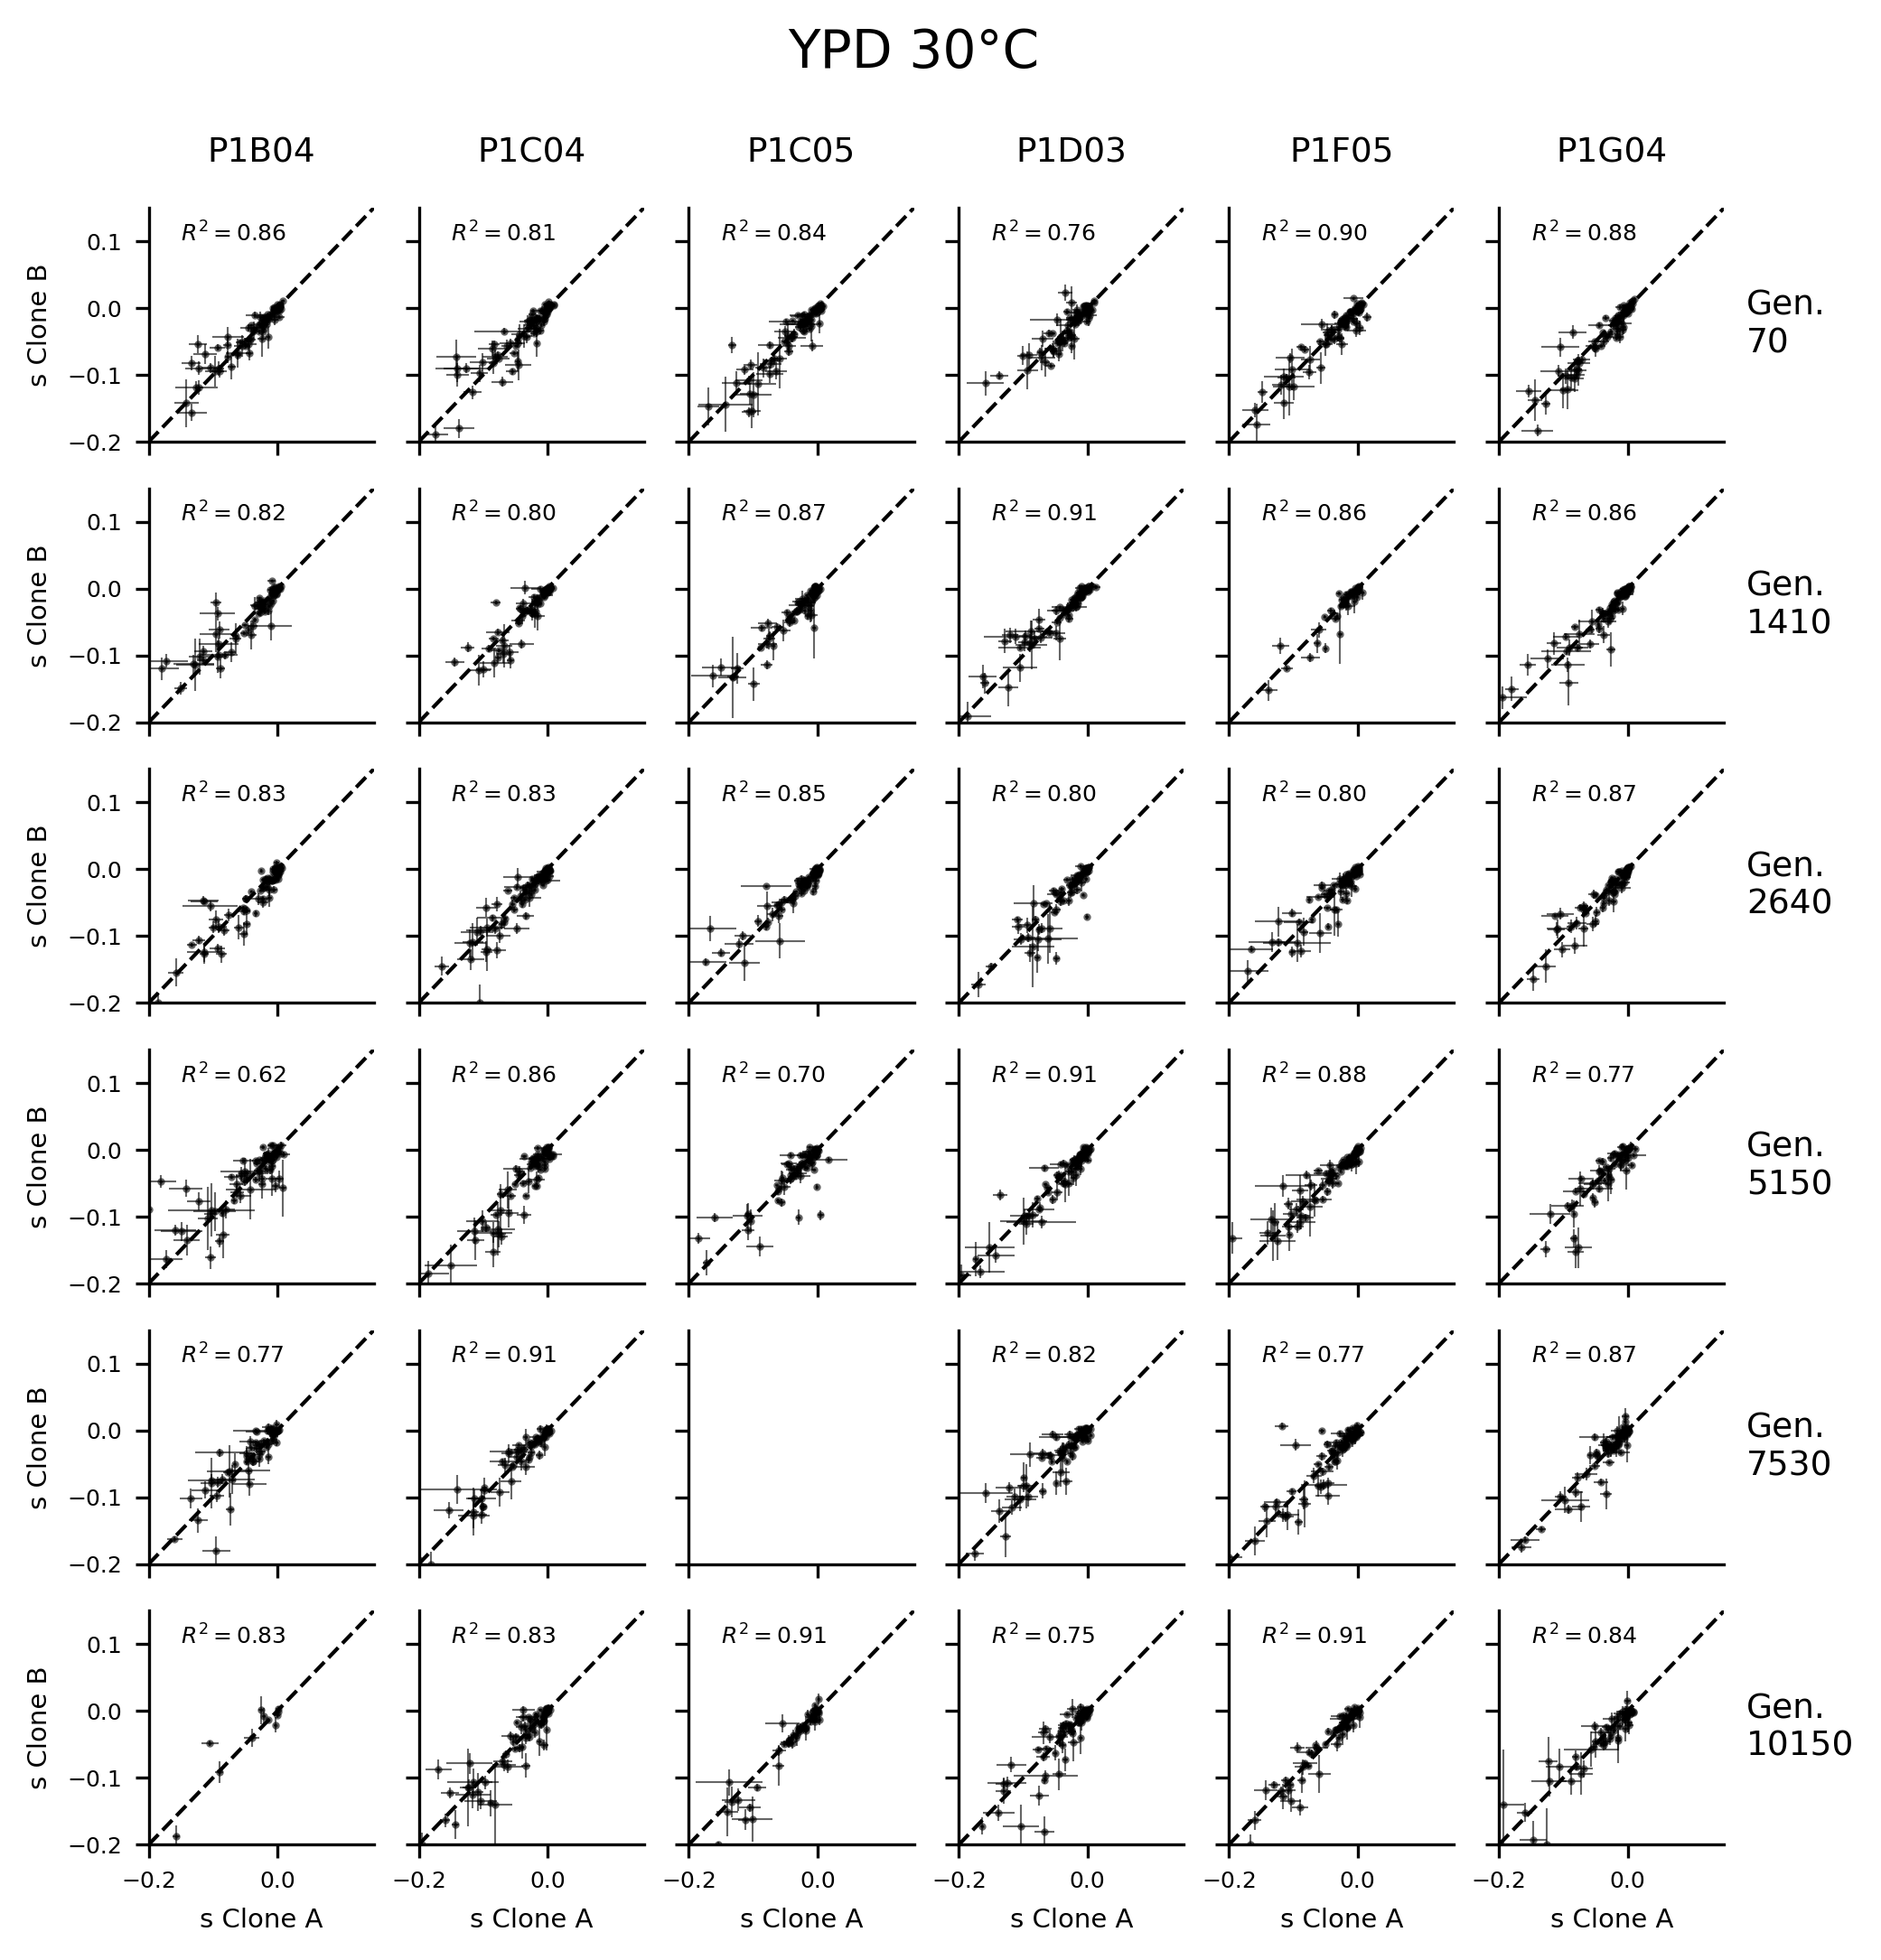

In [14]:
def plot_em(pops, ssd, top_title, outname):
    fig, subps = pl.subplots(6, 6, figsize=(7.5,8), dpi=300, sharex=True, sharey=True)
    for i in range(6):
        gen = gens[i]
        for j in range(6):
            pop = pops[j]
            sub = subps[i][j]
            sub.tick_params(labelsize=6)
            if j == 0:
                sub.set_ylabel('s Clone B', fontsize=7)
            if j == 5:
                sub.annotate('Gen.\n'+str(gen), xy=(1.1, 0.5), xycoords='axes fraction', ha='left', va='center', fontsize=9)
            if i == 0:
                sub.set_title(pop, y=1.1, fontsize=9)
            if i == 5:
                sub.set_xlabel('s Clone A', fontsize=7)
            if 'G'+str(gen)+'_'+pop in ssd:
                td = ssd['G'+str(gen)+'_'+pop]
                td = td[pd.notnull(td['rep1.s']) & pd.notnull(td['rep2.s']) & (td['rep1.cbcs']>=3)  & (td['rep2.cbcs']>=3)]
                if len(td) > 5:
                    sub.plot([-0.2, 0.15], [-0.2, 0.15], c='k', linestyle='dashed', lw=1, zorder=0)
                    sub.errorbar(x=np.clip(td['rep1.s'], -0.2, 0.15), y=np.clip(td['rep2.s'], -0.2, 0.15), xerr=td['rep1.stderr.s'], yerr=td['rep2.stderr.s'], linestyle='', c='k', marker='.', linewidth=0.5, markersize=2, alpha=0.6)
                    #sub.scatter(np.clip(td['rep1.s'], -0.2, 0.15), np.clip(td['rep2.s'], -0.2, 0.15), s=1, alpha=0.6, c='k', zorder=1)
                    sub.set_ylim([-0.2, 0.15])
                    sub.set_xlim([-0.2, 0.15])
                    sub.text(-0.15, 0.1, '$R^2=$'+str(sci_stats.linregress(td['rep1.s'], td['rep2.s'])[2]**2)[:4], fontsize=6)
                    
            else:
                print('missing', 'G'+str(gen)+'_'+pop)
    sns.despine()
    subps[0][2].annotate(top_title, xy=(1, 1.6), xycoords='axes fraction', fontsize=14, ha='center')
    fig.savefig(outname, background='transparent', bbox_inches='tight', pad_inches=0.1)
    
plot_em(p1_pops, sdat_V1, 'YPD 30°C', '../../Figures/supp_figs/s_corr_YPD.pdf')

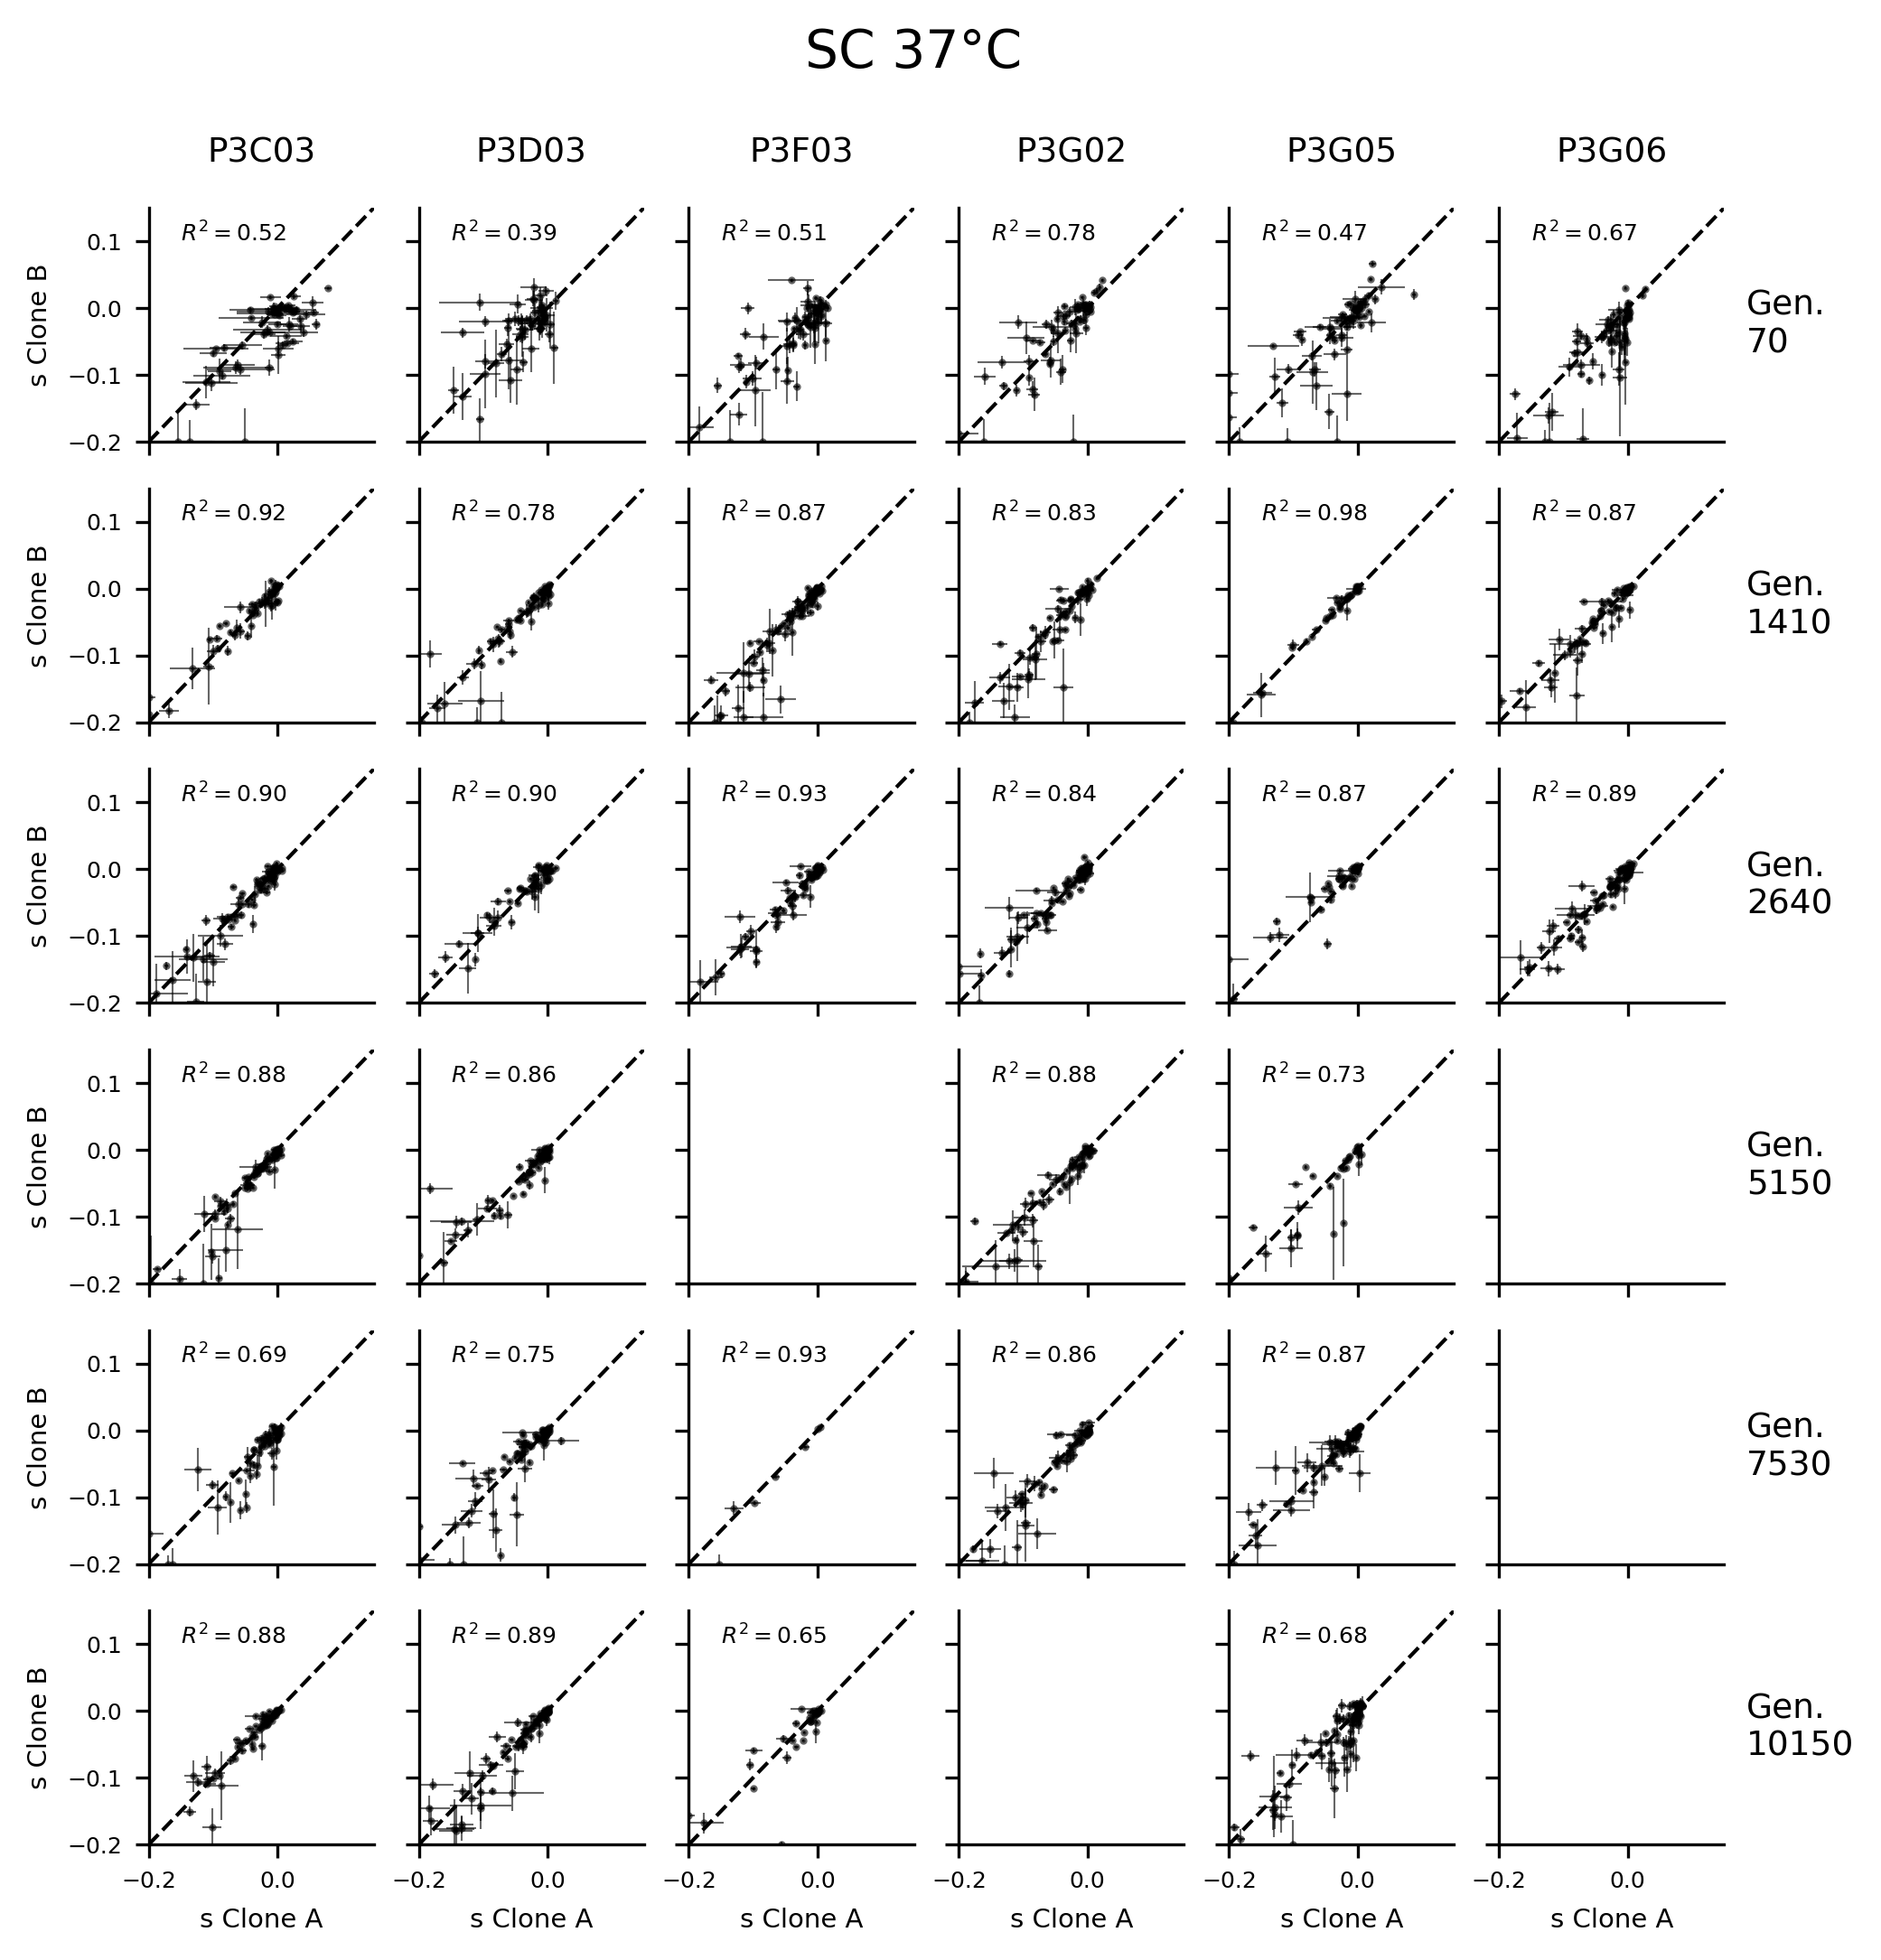

In [15]:
plot_em(p3_pops, sdat_V2, 'SC 37°C', '../../Figures/supp_figs/s_corr_SC.pdf')

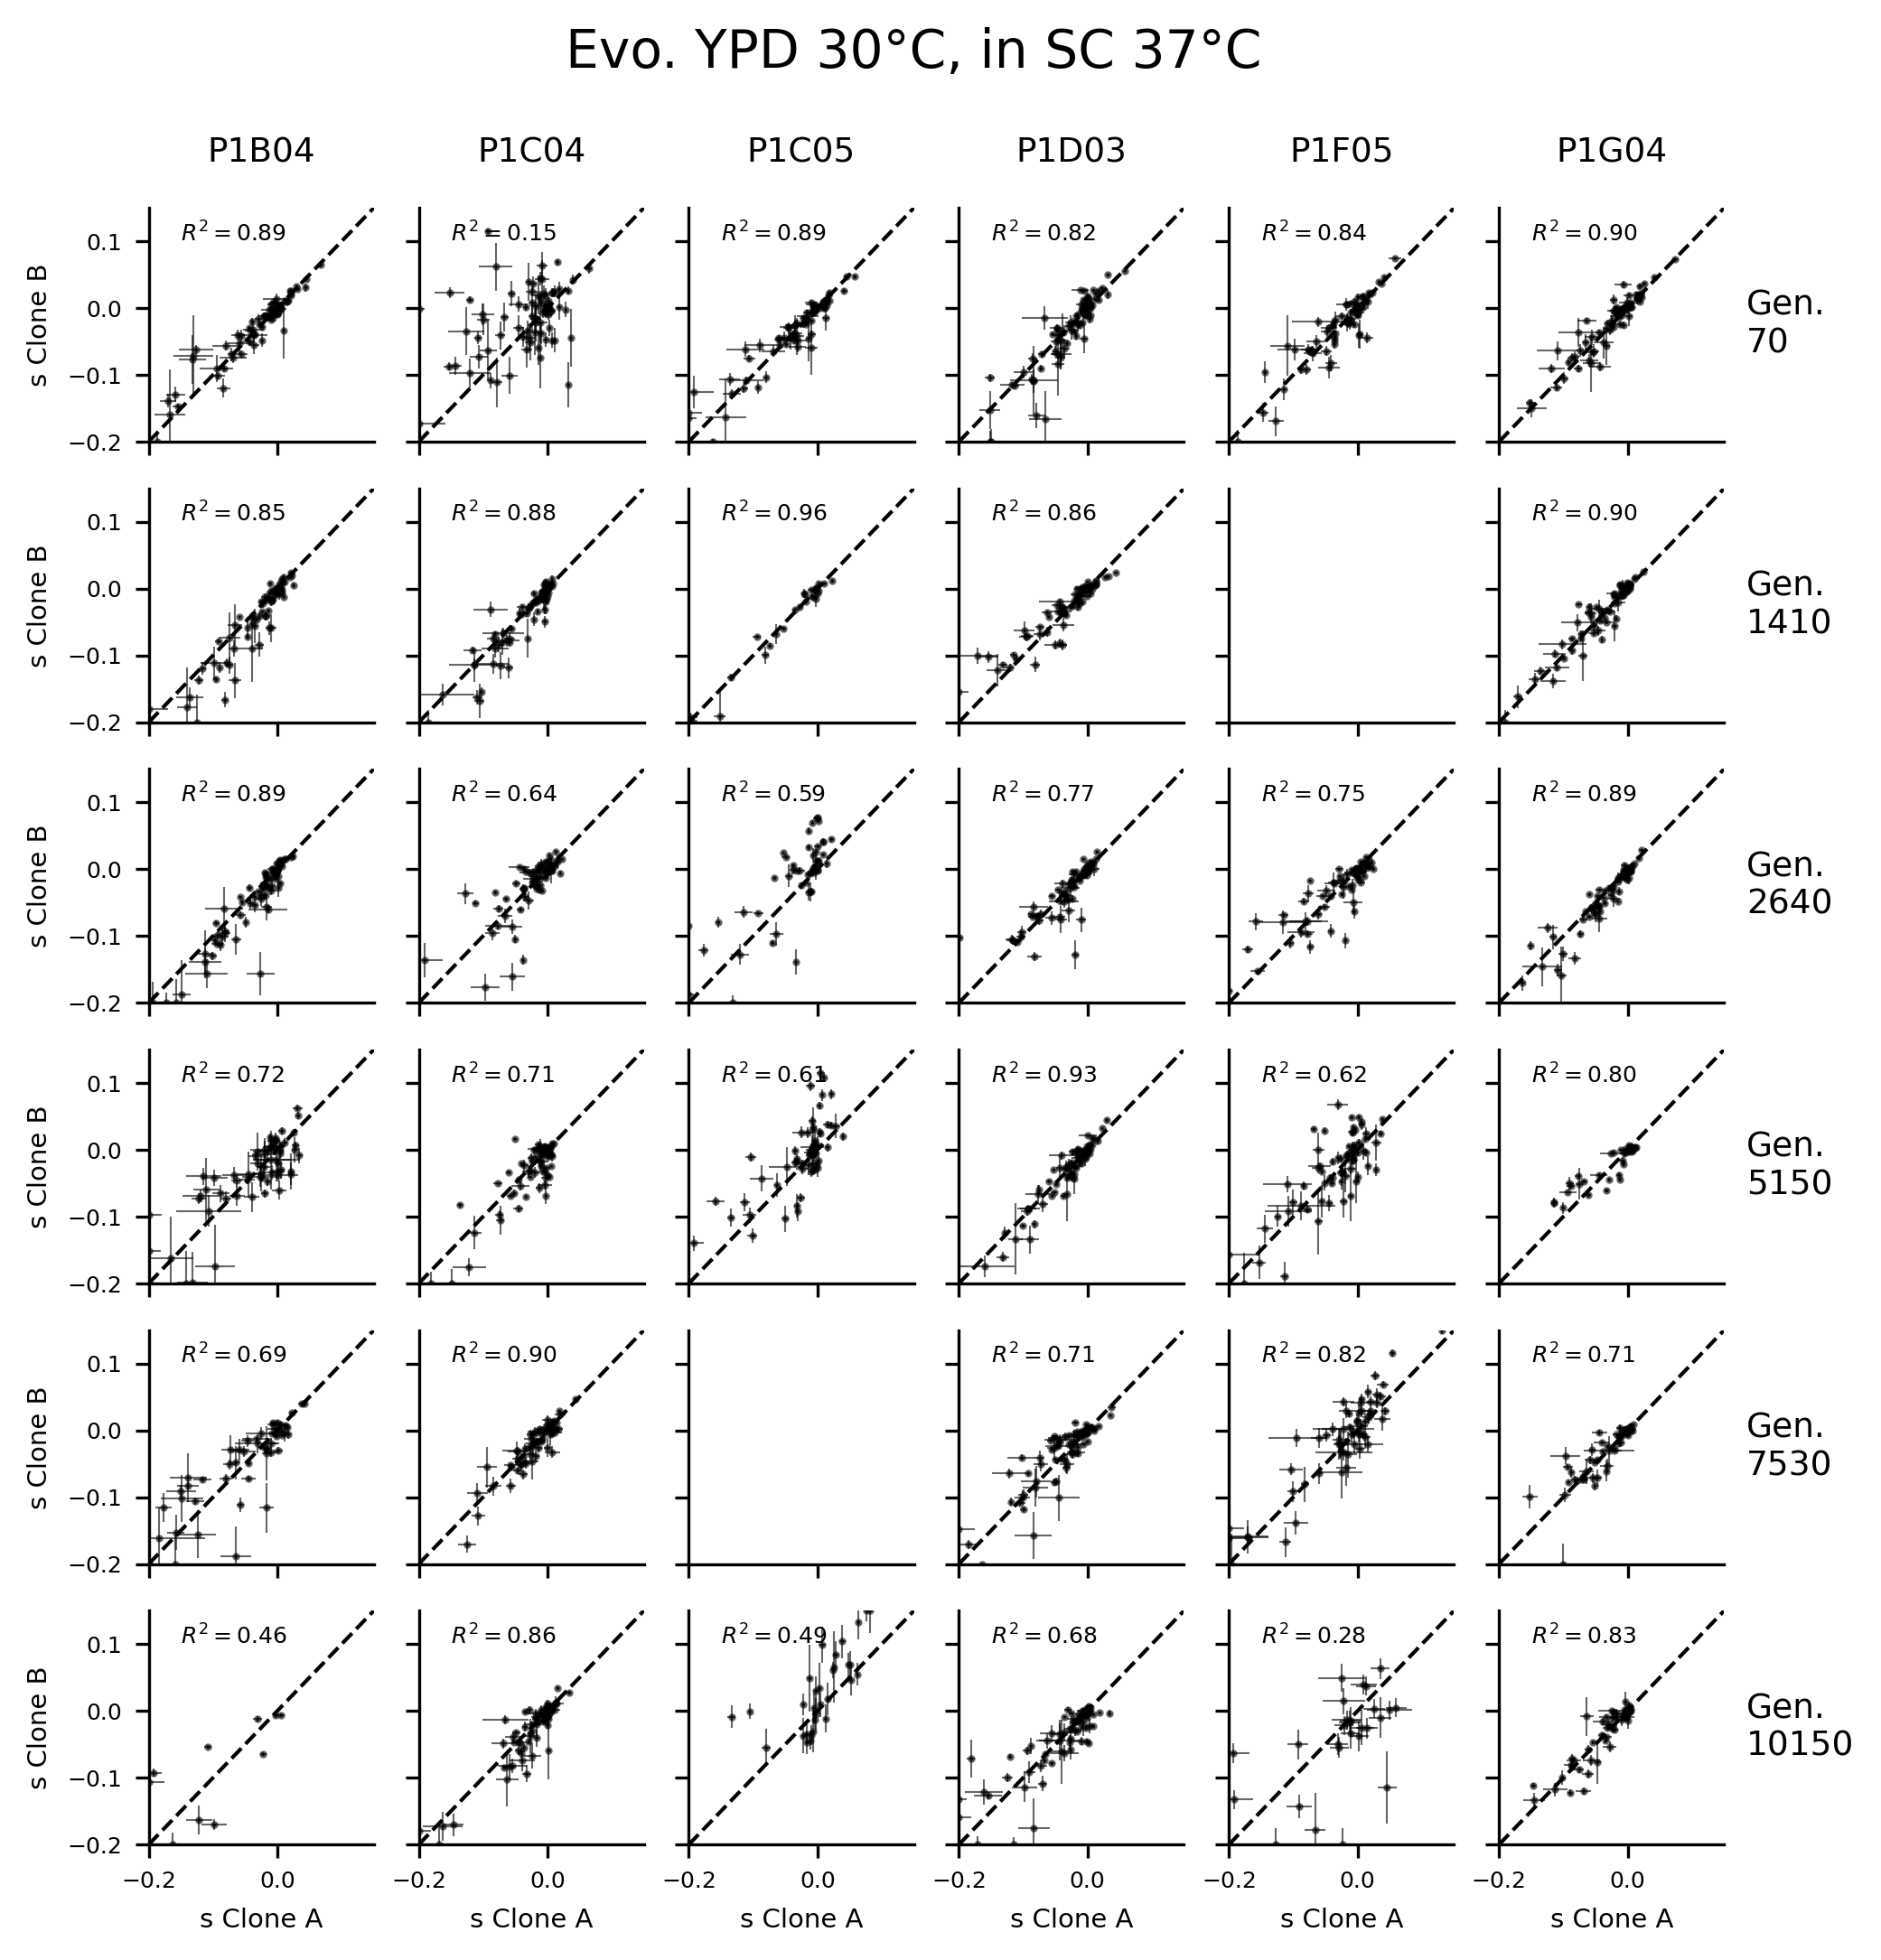

In [16]:
plot_em(p1_pops, sdat_V2, 'Evo. YPD 30°C, in SC 37°C', '../../Figures/supp_figs/s_corr_YPD_in_SC.pdf')